## Simulating Non-Lenses
Author: Paras Sharma ([github:@timedilatesme](https://github.com/timedilatesme), [paras.sharma@stonybrook.edu](paras.sharma@stonybrook.edu))

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.FalsePositives.false_positive_pop import (
    FalsePositiveGalaxiesPop,
    FalsePositiveMultiSourcePop,
)

from slsim.ImageSimulation.image_simulation import (
    simulate_image,
    rgb_image_from_image_list,
)
import numpy as np
from matplotlib import pyplot as plt

from astropy.table import Table, vstack

# warnings
import warnings

warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

## Useful Functions

In [2]:
def make_multiband_images_and_rgb_image(
    lens_class,
    bands=["g", "r", "i", "z", "y"],
    num_pix=41,
    coadd_years=10,
    add_noise=True,
    rgb_bands=["i", "r", "g"],
    rgb_stretch=0.5,
    with_point_source=True,
    with_source=True,
    with_deflector=True,
):
    multiband_image_selected_lens = {}

    # Make multiband images
    for i, band in enumerate(bands):
        simulated_lens_image = simulate_image(
            lens_class=lens_class,
            band=band,
            num_pix=num_pix,
            coadd_years=coadd_years,
            add_noise=add_noise,
            observatory="LSST",
            with_point_source=with_point_source,
            with_source=with_source,
            with_deflector=with_deflector,
        )
        multiband_image_selected_lens[band] = simulated_lens_image

    # Create RGB image (using i, r, g) or other specified bands
    rgb_image = rgb_image_from_image_list(
        image_list=[
            multiband_image_selected_lens[rgb_bands[0]],  # i band
            multiband_image_selected_lens[rgb_bands[1]],  # r band
            multiband_image_selected_lens[rgb_bands[2]],  # g band
        ],
        stretch=rgb_stretch,
    )

    return multiband_image_selected_lens, rgb_image


def plot_montage(
    nonlenses,
    number_to_plot=100,
    num_cols=10,
    bands=["g", "r", "i", "z", "y"],
    rgb_bands=["i", "r", "g"],
    rgb_stretch=0.5,
    with_point_source=True,
    with_extended_source=True,
    with_deflector=True,
    num_pix=41,
    coadd_years=10,
    add_noise=True,
    plot_title=None,
    random_seed=None,
):

    # Randomly select a subset of non-lenses to plot
    if len(nonlenses) > number_to_plot:
        np.random.seed(random_seed)
        random_idxs = np.random.choice(
            len(nonlenses), size=number_to_plot, replace=False
        )
        nonlenses_to_plot = [nonlenses[i] for i in random_idxs]
    else:
        nonlenses_to_plot = nonlenses

    all_rgb_images = []

    for lens_class in nonlenses_to_plot:
        _, rgb_image = make_multiband_images_and_rgb_image(
            lens_class,
            bands=bands,
            num_pix=num_pix,
            coadd_years=coadd_years,
            add_noise=add_noise,
            with_point_source=with_point_source,
            with_source=with_extended_source,
            with_deflector=with_deflector,
            rgb_bands=rgb_bands,
            rgb_stretch=rgb_stretch,
        )

        all_rgb_images.append(rgb_image)

    # montage of all RGB images in a dynamic grid
    num_images = len(all_rgb_images)
    num_rows = int(np.ceil(num_images / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(all_rgb_images[i], origin="lower")
            ax.axis("off")
        else:
            ax.remove()  # Remove unused subplots
    plt.tight_layout()
    if plot_title:
        plt.suptitle(plot_title, fontsize=16)
        plt.subplots_adjust(top=0.95)  # Adjust top to make room for title

    fig.tight_layout()

    return fig

## Load a Precomputed Quasar Catalog with Host Information

In [19]:
## load a small quasar catalog with host info

quasar_host_catalog = Table.read(
    "../tests/TestData/qso_host_catalog.fits", format="fits"
)  # ['z', 'ps_mag_g', 'ps_mag_r', 'ps_mag_i', 'ps_mag_z', 'ps_mag_y']
quasar_catalog_sky_area = (
    12.0  # square degrees, this is for the small test catalog with host info.
)

quasar_host_catalog[:5]

<Table length=5>
     ps_mag_u           ps_mag_g      ...    log_lambda_Edd   
       mag                mag         ...                     
     float64            float64       ...       float64       
------------------ ------------------ ... --------------------
25.526410294184743 24.690005684030368 ...  -0.9173346781085439
 32.18496611118078 31.407239505595456 ... -0.06846630171891999
22.141568104568897  21.85962065938283 ... -0.05361264386462583
26.029361495632347  25.57729026071811 ...  -0.1819456003992972
22.352179172101113 22.146556889006604 ... -0.33707302240494474

In [7]:
# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Define areas
sky_area_galaxy = Quantity(2, "deg2")
sky_area_quasar = Quantity(quasar_catalog_sky_area, "deg2")

# generate skypy galaxy catalog
galaxy_pipeline = pipelines.SkyPyPipeline(sky_area=sky_area_galaxy, cosmo=cosmo)
red_galaxy_catalog = galaxy_pipeline.red_galaxies
blue_galaxy_catalog = galaxy_pipeline.blue_galaxies
all_galaxy_catalog = vstack([red_galaxy_catalog, blue_galaxy_catalog])

## Make Source and Deflectors Populations

In [9]:
# source and deflector cuts
kwargs_deflector_cut = {"band": "i", "band_max": 24, "z_min": 0.01, "z_max": 2}
kwargs_source_galaxy_cut = {"band": "i", "band_max": 26, "z_min": 0.01, "z_max": 5.0}
kwargs_source_quasar_cut = {"band": "i", "band_max": 26, "z_min": 0.01, "z_max": 5.0}

In [10]:
lens_galaxy_pop = deflectors.AllLensGalaxies(
    red_galaxy_list=red_galaxy_catalog,
    blue_galaxy_list=blue_galaxy_catalog,
    gamma_pl={"mean": 2.0, "std_dev": 0.16},
    kwargs_cut=kwargs_deflector_cut,
    cosmo=cosmo,
    kwargs_mass2light=None,
    sky_area=sky_area_galaxy,
)
source_galaxy_pop = sources.Galaxies(
    galaxy_list=blue_galaxy_catalog,
    kwargs_cut=kwargs_source_galaxy_cut,
    cosmo=cosmo,
    sky_area=sky_area_galaxy,
    catalog_type="skypy",
)
field_galaxy_pop = sources.Galaxies(
    galaxy_list=all_galaxy_catalog,
    kwargs_cut=kwargs_source_galaxy_cut,
    cosmo=cosmo,
    sky_area=sky_area_galaxy,
    catalog_type="skypy",
)
source_quasar_host_pop = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_host_catalog,
    cosmo=cosmo,
    sky_area=sky_area_quasar,
    point_source_type="quasar",
    extended_source_type="double_sersic",
    kwargs_cut=kwargs_source_quasar_cut,
)

## Draw and Visualize Non-Lenses

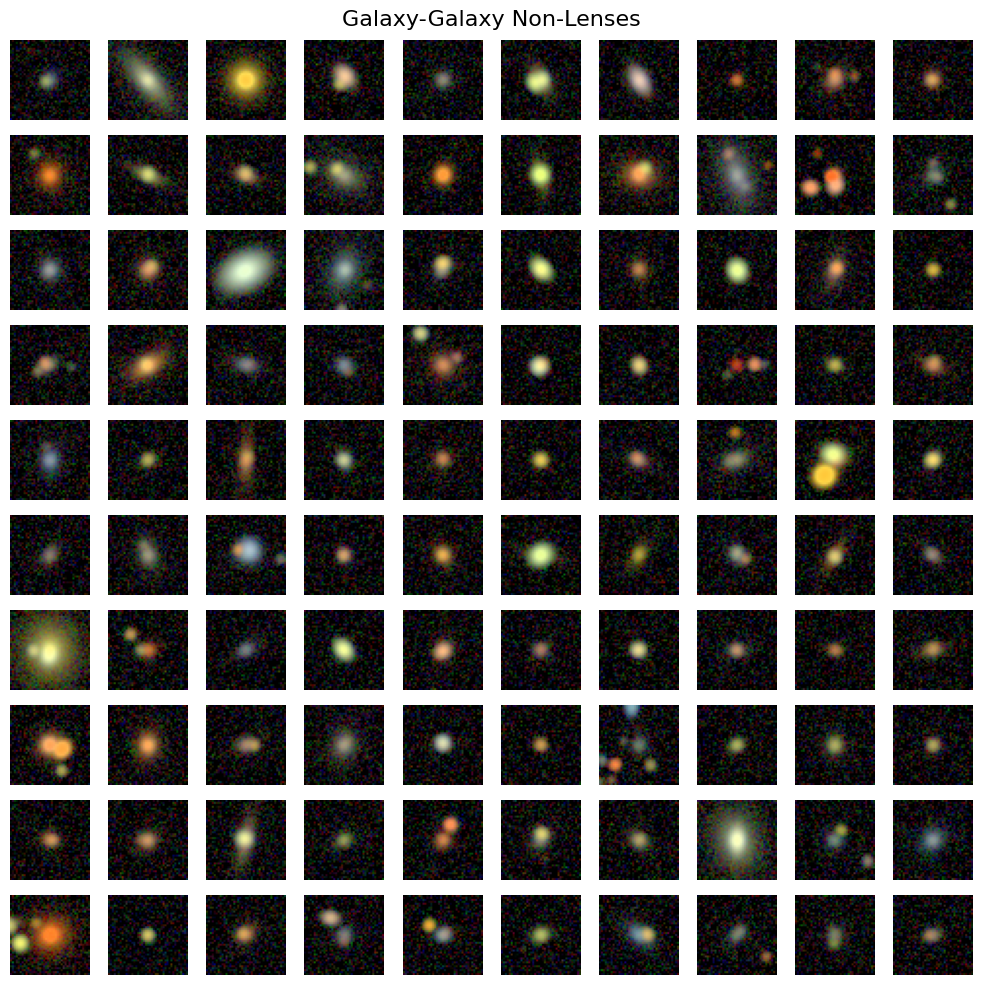

In [ ]:
fp_galaxy_galaxy_pop = FalsePositiveGalaxiesPop(
    central_galaxy_population=lens_galaxy_pop,
    surrounding_galaxy_population=source_galaxy_pop,
    source_number_choice=[
        1
    ],  # places 1 source galaxies near the lens galaxy to create a non-lens system with multiple nearby galaxies
    cosmo=cosmo,
    include_central_galaxy_light=True,
    field_galaxy_population=field_galaxy_pop,  # includes additional galaxies in the field of view that are not near the lens galaxy, to create a more realistic non-lens system with multiple nearby galaxies
)
galaxy_galaxy_nonlenses = fp_galaxy_galaxy_pop.draw_false_positive(1000)

plot_montage(
    galaxy_galaxy_nonlenses, number_to_plot=100, plot_title="Galaxy-Galaxy Non-Lenses"
);

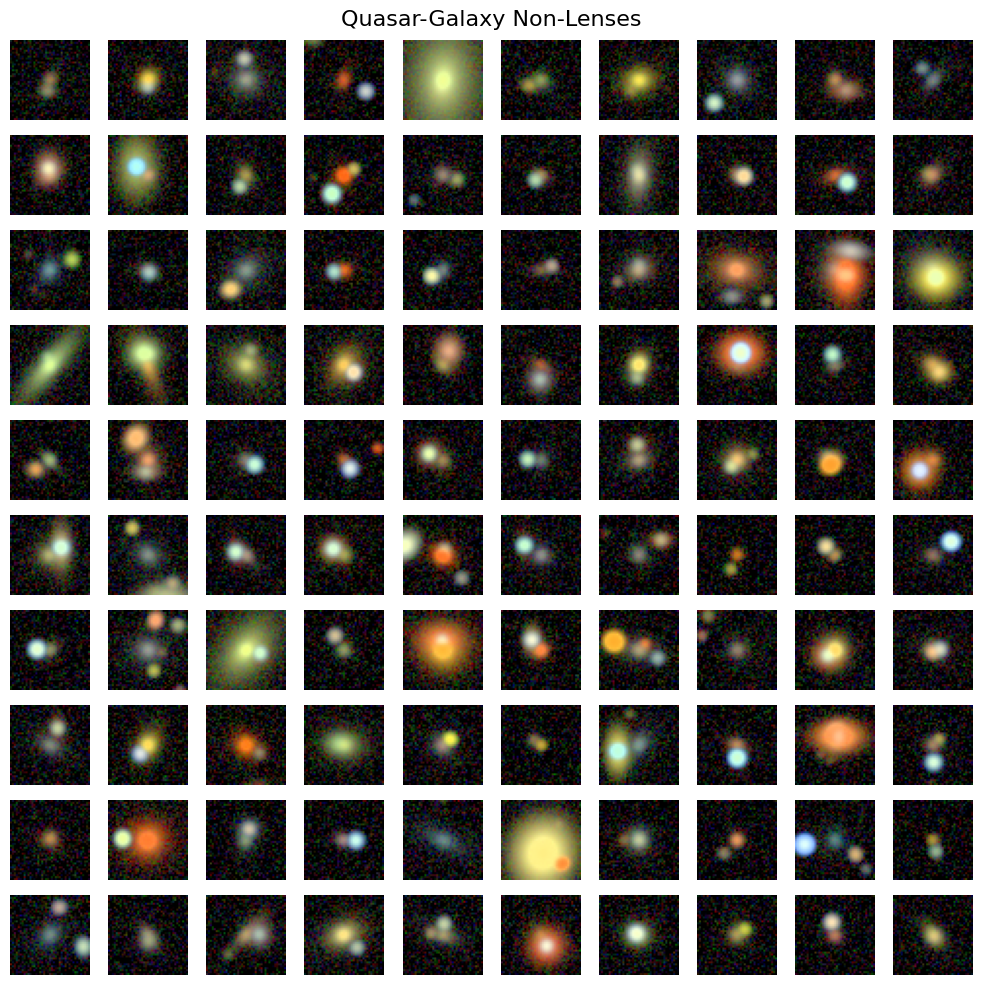

In [14]:
fp_qso_qso_pop = FalsePositiveMultiSourcePop(
    central_galaxy_population=lens_galaxy_pop,
    source_populations=[source_quasar_host_pop],
    source_number_choices=[
        [1]
    ],  # places 1 quasar near the lens galaxy to create a non-lens system with a single nearby point source
    cosmo=cosmo,
    clustering_mode="random",
    include_central_galaxy_light=True,
    field_galaxy_population=field_galaxy_pop,
)
qso_qso_nonlenses = fp_qso_qso_pop.draw_false_positive(1000)

plot_montage(
    qso_qso_nonlenses, number_to_plot=100, plot_title="Quasar-Galaxy Non-Lenses"
);

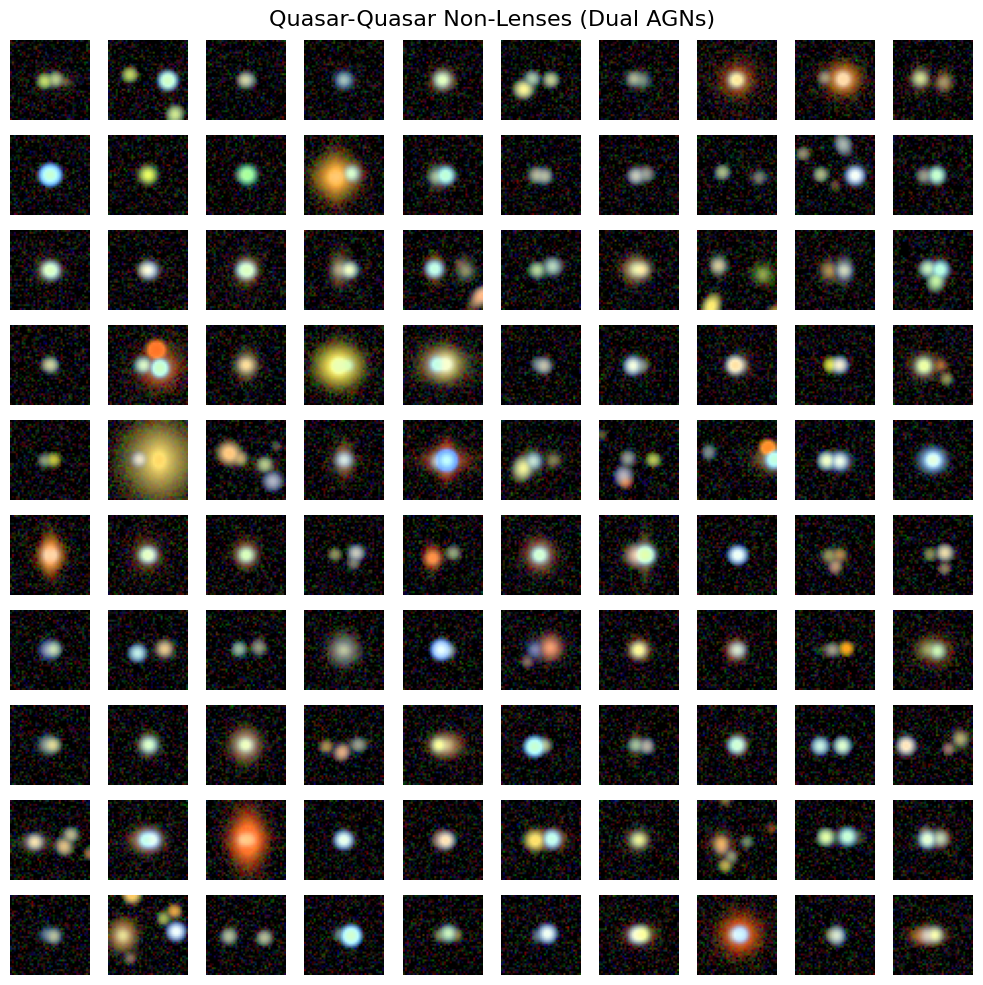

In [16]:
# Dual AGN Non-Lenses
fp_qso_qso_pop = FalsePositiveMultiSourcePop(
    central_galaxy_population=lens_galaxy_pop,
    source_populations=[source_quasar_host_pop, source_quasar_host_pop],
    source_number_choices=[[1], [1]],
    cosmo=cosmo,
    clustering_mode="ring",
    include_central_galaxy_light=False,
    field_galaxy_population=field_galaxy_pop,
)
qso_qso_nonlenses = fp_qso_qso_pop.draw_false_positive(1000)

plot_montage(
    qso_qso_nonlenses,
    number_to_plot=100,
    plot_title="Quasar-Quasar Non-Lenses (Dual AGNs)",
);